In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp


In [51]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))


def inverse_sigmoid(y):
    return np.log(y / (1. - y))


def plot_trajectory(params_trajectory, optimal=None, figtitle=None):

    T = params_trajectory.shape[0]
    # time points for which we want to evaluate solutions
    t = np.arange(0, T)

    # make a color map to visualize time
    timecolors = np.array([(1, 0, 0, i) for i in t / t[-1]])

    # make a large figure
    fig, (ah1, ah2, ah3) = plt.subplots(1, 3)
    fig.set_size_inches(10, 3)

    # plot x1 as a function of time
    ah1.scatter(t, params_trajectory[:, 0], color=timecolors)
    ah1.set_xlabel('time')
    ah1.set_ylabel('logZ', labelpad=-5)

    # plot x2 as a function of time
    ah2.scatter(t, params_trajectory[:, 1], color=timecolors)
    ah2.set_xlabel('time')
    ah2.set_ylabel('x', labelpad=-5)

    # plot x1 and x2 in a phase portrait
    ah3.scatter(params_trajectory[:, 0],
                params_trajectory[:, 1], color=timecolors)
    ah3.set_xlabel('logZ')
    ah3.set_ylabel('x', labelpad=-5)
    # include initial condition is a blue cross
    ah3.plot(params_trajectory[0, 0], params_trajectory[0, 1], 'bx')

    if optimal is not None:
        ah3.plot(optimal[0], optimal[1], 'gx')

    # adjust spacing between subplots
    plt.subplots_adjust(wspace=0.5)

    # add figure title
    if figtitle is not None:
        fig.suptitle(figtitle, size=16)


### N = 2

In [100]:
def one_step(params, lr1, lr2, log_rew_1, log_rew_2, prob_s0_s2=0.1):
    rand = np.random.rand()
    if rand < prob_s0_s2:
        grad_1 = 2 * (params[0] + np.log(sigmoid(- params[1])) - log_rew_2)
        grad = grad_1 * np.array([1, -sigmoid(params[1])])
    else:
        grad_1 = 2 * (params[0] + np.log(sigmoid(params[1])) - log_rew_1)
        grad = grad_1 * np.array([1, 1 - sigmoid(params[1])])
    new_params = params - np.array([lr1, lr2]) * grad
    return new_params


In [127]:
lr1, lr2 = 0.01, 0.01
log_rew_1 = np.log(2)
log_rew_2 = 0.


In [156]:
prob_s0_s2 = 0.

horizon = 200
params = np.array([4., 0.])


params_trajectory = np.zeros((horizon, 2))
params_trajectory[0] = params

for t in range(horizon - 1):
    params = one_step(params, lr1, lr2, log_rew_1, log_rew_2, prob_s0_s2)
    params_trajectory[t+1] = params


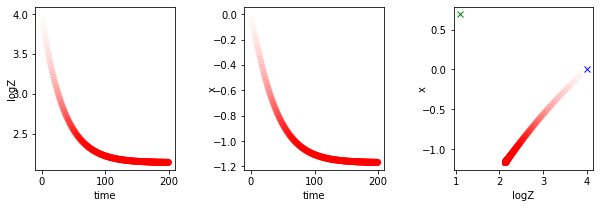

In [157]:
opt_log_Z = logsumexp([log_rew_1, log_rew_2])
optimal = np.array([opt_log_Z, inverse_sigmoid(
    np.exp(log_rew_1) / np.exp(opt_log_Z))])
plot_trajectory(params_trajectory, optimal=optimal)


In [159]:
print(params_trajectory[-1])
print(optimal)
print((params_trajectory[-10:, 0] - (log_rew_1 -
      np.log(sigmoid(params_trajectory[-10:, 1]))))**2)


[ 2.13729608 -1.16768706]
[1.09861229 0.69314718]
[5.60573892e-05 5.25672612e-05 4.92943645e-05 4.62251842e-05
 4.33470456e-05 4.06480621e-05 3.81170863e-05 3.57436638e-05
 3.35179906e-05 3.14308724e-05]


### N > 2

In [289]:
N = 10


def reward(i):
    # i = 1.. N
    return i


def init_params():
    # the first parameter is y=logZ, the others are x_i s.t P(s_i | s_0) = softmax(x_i) for i >
    params = np.zeros(N + 1)
    params[1] = np.log(reward(1))  # convention x_1 = log R_1
    return params


In [295]:
def one_step_N(params, lr1, lr2, i):
    # i = 1..N
    log_X = logsumexp(params[1:])
    grad_1 = 2 * (params[0] + params[i] - log_X - np.log(reward(i)))
    grad_mult = np.ones(N + 1)
    grad_mult[1:] = np.exp(params[1:] - log_X)
    grad_mult[i] = 1 - np.exp(params[i] - log_X)
    grad = grad_mult * grad_1
    lrs = lr2 * np.ones(N + 1)
    lrs[0] = lr1
    lrs[1] = 0
    new_params = params - lrs * grad
    return new_params


In [296]:
lr1, lr2 = 0.2, 0.02
horizon = 5000
params = init_params()


params_trajectory = np.zeros((horizon, N + 1))
params_trajectory[0] = params

for t in range(horizon - 1):
    while True:
        i = 1 + np.random.randint(N)
        if i > N-3:
            break
    params = one_step_N(params, lr1, lr2, i)
    params_trajectory[t+1] = params


In [297]:
opt_log_Z = np.log(np.sum([reward(i) for i in range(1, N + 1)]))
optimal_params = np.zeros(N + 1)
optimal_params[1:] = np.log([reward(i) for i in range(1, N + 1)])
optimal_params[0] = opt_log_Z


In [298]:
print(params_trajectory[-1])
print(optimal_params)


[4.41142706 0.         0.04357509 0.04357509 0.04357509 0.04357509
 0.04357509 0.04357509 0.04847279 0.16625583 0.27161634]
[4.00733319 0.         0.69314718 1.09861229 1.38629436 1.60943791
 1.79175947 1.94591015 2.07944154 2.19722458 2.30258509]


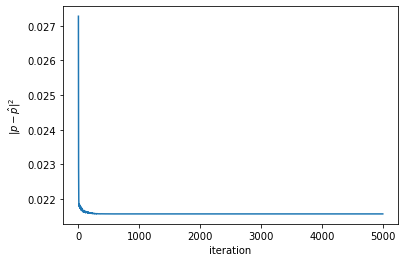

In [299]:
def get_dist(params):
    return np.exp(params[1:]) / np.sum(np.exp(params[1:]))


true_dist = get_dist(optimal_params)

distances = [np.sum((true_dist - get_dist(params_trajectory[t, :])) ** 2)
             for t in range(horizon)]

plt.plot(range(horizon), distances)
plt.xlabel('iteration')
plt.ylabel(r'$|p - \hat{p}|^2$')
plt.show()


In [244]:
params_trajectory[:, -1]


array([0.        , 0.17999239, 0.25287204, ..., 0.32881735, 0.32881735,
       0.32881735])

In [225]:
t


4998

In [226]:
(true_dist - get_dist(params_trajectory[t, :])) ** 2


array([2.85344222e-18, 5.14721514e-20, 2.66736479e-19, 4.04220161e-20,
       3.93134892e-21, 2.71217075e-20, 5.25008334e-20, 1.53577897e-18,
       3.87443183e-19, 1.68359527e-22])